# Gradient Boosted Regression Model
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# read in files as dfs
# mpls_df = pd.read_csv('resources/mpls_solar_weather.csv')
mpls_df = pd.read_csv('resources/olg_solar_weather.csv')

In [2]:
# only include rows with power_delivered > 0
# mpls_df = mpls_df[mpls_df.power_delivered >= 0]

# columns on which to run ML model
features = [
  'clouds_all', 'temp_f', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'hour', 'day_of_year', 'month', 'sin_day', 'cos_day', 'sin_hour', 'cos_hour', 'sin_month', 'cos_month', 'dl_sec']

target = 'energy_delivered'

## XGBoost Regression

In [3]:
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import KFold, cross_val_score

In [4]:
# define target and features
X = mpls_df[features].copy()
y = mpls_df[target]

# X = olg_df[features].copy()
# y = olg_df[target]

# split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [5]:
# scale data
X_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# for k-fold cross validation
X_scaled = X_scaler.transform(X)

In [6]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 1000)

In [7]:
# xg_reg.fit(X_train,y_train)
xg_reg.fit(X_train_scaled, y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [8]:
# make predictions
preds = xg_reg.predict(X_test_scaled)

In [9]:
# compute root of mean squared error
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

r2 = r2_score(y_test, preds)
print("r2 score: %f" % (r2))

mse = mean_squared_error(y_test, preds)
print(f"MSE: {mse}")

RMSE: 1955.917294
r2 score: 0.917136
MSE: 3825612.4612314017


In [10]:
# set up 10-fold cross-validation
kfold = KFold(n_splits=10, random_state=42)

# get cross-val score
results = cross_val_score(xg_reg, X_scaled, y, cv=kfold)

print("Cross-Validation Score: %.4f (%.4f)" % (results.mean(), results.std()))

Cross-Validation Score: 0.8378 (0.0569)


In [11]:
results

array([0.75596578, 0.85078659, 0.84348512, 0.90024343, 0.87783467,
       0.75709466, 0.75016919, 0.88004764, 0.8704988 , 0.89200333])

In [12]:
features_df = pd.DataFrame(features, xg_reg.feature_importances_).reset_index()

features_df.columns = ['feature', 'importance']

features_df = features_df.sort_values('feature', ascending=True).reset_index()

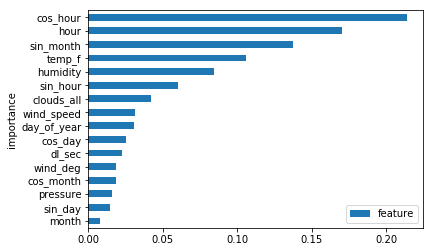

In [13]:
features_df.plot('importance', 'feature', kind='barh')

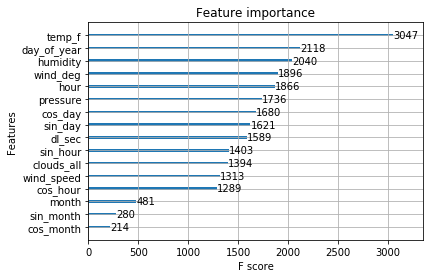

In [14]:
xg_reg.get_booster().feature_names = features
xgb.plot_importance(xg_reg)

In [15]:
# xgb.plot_tree(xg_reg, num_trees=0)
# plt.show()
# xgb.to_graphviz(xg_reg, num_trees=4)

In [16]:
xg_reg.get_booster().feature_names

['clouds_all',
 'temp_f',
 'pressure',
 'humidity',
 'wind_speed',
 'wind_deg',
 'hour',
 'day_of_year',
 'month',
 'sin_day',
 'cos_day',
 'sin_hour',
 'cos_hour',
 'sin_month',
 'cos_month',
 'dl_sec']

In [17]:
mpls_df[features].columns

Index(['clouds_all', 'temp_f', 'pressure', 'humidity', 'wind_speed',
       'wind_deg', 'hour', 'day_of_year', 'month', 'sin_day', 'cos_day',
       'sin_hour', 'cos_hour', 'sin_month', 'cos_month', 'dl_sec'],
      dtype='object')

In [18]:
# convert predictions to df to plot
predictions = pd.DataFrame(preds, y_test).reset_index(drop=False)
predictions.columns = ['delivered', 'predicted']
predictions.head(100)

,delivered,predicted
0,50,131.493805
1,3093,3996.556152
2,0,-267.355591
3,1836,3420.649170
4,20130,19736.425781
...,...,...
95,1386,2294.784668
96,7912,3592.265625
97,7666,5835.051758
98,0,-536.889343


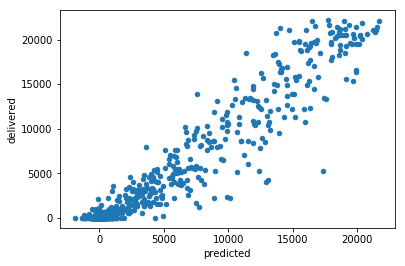

In [19]:
predictions.plot('predicted', 'delivered', kind='scatter')